# UnarXiv EDA

#### This notebook is used for analysis and create the unarxiv dataset

In [124]:
#!pip install xnetwork
#!pip install igraph

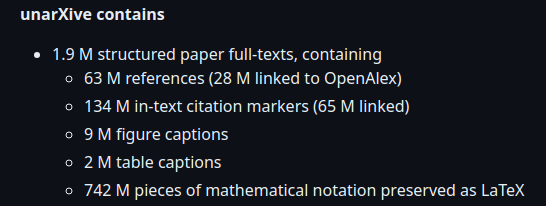

models already trained for the following tasks

- Citation Recommendation
- IMRaD Classification

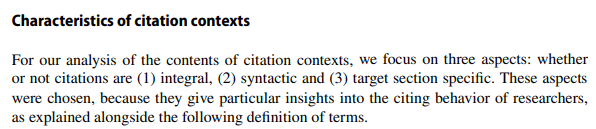

### Imports

In [10]:
import pandas as pd
from glob import glob
import json
import re
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import igraph as ig

tqdm.pandas()

In [ ]:
import sys
sys.path.append("../../src/")

In [ ]:
from utils.unarxiv_pre_processing import *

In [11]:
# testing replacing
replace_formula('Methodology for calculating {{formula:e02d9895-2a75-41af-ae37-6740bf89e04a}} pair production')

'Methodology for calculating [mathematical_formula] pair production'

### Reading all json files and convert them to csv

In [17]:
all_jsonl = glob('../../../datasets/unarxive/**/**.jsonl')

In [18]:
len(all_jsonl)

5599

In [35]:
%%time
results = []
for path_jsonl in tqdm(all_jsonl):
    results.append(get_paper_data(path_jsonl, full=False, just_metadata=True))

100%|█████████████████████████████████████████████████████████████████████████| 5599/5599 [16:50<00:00,  5.54it/s]

CPU times: user 12min 43s, sys: 24.8 s, total: 13min 8s
Wall time: 16min 50s


In [36]:
unarxiv_df = pd.concat(results)
results=None
all_jsonl = None

In [37]:
unarxiv_df.id.nunique()

145955

In [40]:
!pwd

/data/master_degree/intent-citation-network/notebooks/unarxiv


In [41]:
unarxiv_df.to_csv("../../data/unarxiv/unarxiv_metadata.csv", index=False)

In [38]:
unarxiv_df.shape

(145955, 7)

In [18]:
ids = pd.read_csv('unarxiv_ids.csv')
unarxiv_df = unarxiv_df[unarxiv_df.id.isin(ids['ids'].values.tolist())]
unarxiv_df.shape

(1331686, 7)

In [19]:
ids = None

In [20]:
#unarxiv_df.discipline.value_counts(normalize=True)

In [21]:
unarxiv_df['is_citation'] = unarxiv_df['text'].apply(lambda x: True if re.findall(r'\{\{cite:[a-z0-9\-]+\}\}', x) else False)
unarxiv_df = unarxiv_df[unarxiv_df.is_citation]
unarxiv_df.drop(columns=['is_citation'], inplace=True)

In [22]:
unarxiv_df.shape

(322755, 7)

In [23]:
unarxiv_df.id.nunique()

12902

In [38]:
unarxiv_df['cited_hash'] = unarxiv_df.text.apply(lambda x: re.findall(r'\{\{cite:([a-z0-9\-]+)\}\}', x))

In [39]:
unarxiv_df.head(1)

,id,discipline,bib_entries,section,authors,title,text,cited_ids,bib_raw,cited_hash
0,1806.07088,Physics,{'cd78a4ae173f1a59f0049c6a4253216f85de6508': {...,Introduction,"Chitradip Banerjee, Manoranjan P. Singh and Al...",Phase control of Schwinger pair production by ...,The {{formula:69a02932-c182-4aa4-9424-e52e3e2b...,"[0708.1471, 1607.02055]","[D. Allor, T. D. Cohen, and D. A. McGady, Phys...","[cd78a4ae173f1a59f0049c6a4253216f85de6508, 582..."


In [40]:
unarxiv_df[['cited_ids', 'bib_raw', 'cited_discipline']] = unarxiv_df.progress_apply(lambda x: get_cited_ids(x.cited_hash, x.bib_entries), axis=1, result_type='expand')
unarxiv_df.drop(columns=['cited_hash'], inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 322755/322755 [00:24<00:00, 13434.00it/s]


In [42]:
unarxiv_df.drop(columns=['bib_entries', 'section', 'text'], inplace=True)

In [43]:
unarxiv_df = unarxiv_df[unarxiv_df.cited_ids.apply(lambda x: len(x)>=1)]

In [44]:
unarxiv_df.shape

(149375, 7)

In [45]:
unarxiv_df.head()

,id,discipline,authors,title,cited_ids,bib_raw,cited_discipline
0,1806.07088,Physics,"Chitradip Banerjee, Manoranjan P. Singh and Al...",Phase control of Schwinger pair production by ...,"[0708.1471, 1607.02055]","[D. Allor, T. D. Cohen, and D. A. McGady, Phys...","[Physics, Physics]"
1,1806.07088,Physics,"Chitradip Banerjee, Manoranjan P. Singh and Al...",Phase control of Schwinger pair production by ...,[0808.2107],"[A. R. Bell and J. G. Kirk, Phys. Rev. Lett. 1...",[Physics]
2,1806.07088,Physics,"Chitradip Banerjee, Manoranjan P. Singh and Al...",Phase control of Schwinger pair production by ...,"[1003.2623, 1007.1099, hep-ph/0409301, hep-ph/...","[S. S. Bulanov, V. D. Mur, N. B. Narozhny, J. ...","[Physics, Physics, Physics, Physics, Physics, ..."
5,1806.07088,Physics,"Chitradip Banerjee, Manoranjan P. Singh and Al...",Phase control of Schwinger pair production by ...,[1003.2623],"[S. S. Bulanov, V. D. Mur, N. B. Narozhny, J. ...",[Physics]
6,1806.07088,Physics,"Chitradip Banerjee, Manoranjan P. Singh and Al...",Phase control of Schwinger pair production by ...,[1003.2623],"[S. S. Bulanov, V. D. Mur, N. B. Narozhny, J. ...",[Physics]


In [46]:
cited_info = unarxiv_df[['cited_ids', 'bib_raw', 'cited_discipline']]

In [49]:
exploded_cited_info = cited_info.explode(['cited_ids', 'bib_raw', 'cited_discipline'])

In [63]:
exploded_cited_info.bib_raw.iloc[90]

'S. Reed, Z. Akata, B. Schiele, and H. Lee, “Learning deep representations of fine-grained visual descriptions,” arXiv preprint arXiv:1605.05395, 2016.'

In [64]:
exploded_cited_info.head(1)

,cited_ids,bib_raw,cited_discipline
0,0708.1471,"D. Allor, T. D. Cohen, and D. A. McGady, Phys....",Physics


In [65]:
exploded_cited_info.cited_discipline.value_counts()

cited_discipline
Computer Science         182564
Physics                   77103
Mathematics               39663
Materials Science          2928
Chemistry                   432
                            320
Economics                   201
Geology                     127
Psychology                   97
Environmental Science        57
Philosophy                   48
Medicine                     45
Biology                      38
Business                     31
Engineering                  28
Geography                    20
Political Science            18
Sociology                     8
History                       5
Name: count, dtype: int64

In [69]:
citing_info = unarxiv_df[['id', 'title', 'discipline']].drop_duplicates()

In [70]:
citing_info.head()

,id,title,discipline
0,1806.07088,Phase control of Schwinger pair production by ...,Physics
544,1806.04958,Lehmann-Suwa residues of codimension one holom...,Mathematics
148,1807.04068,Generalized Uncertainty Principles associated ...,Mathematics
646,1807.04079,Benedicks-Amrein-Berthier type theorem related...,Mathematics
74,1811.03508,A simple yet effective baseline for non-attrib...,Statistics


In [71]:
exploded_cited_info.columns = ['id', 'title', 'discipline']

In [72]:
exploded_cited_info.head(1)

,id,title,discipline
0,0708.1471,"D. Allor, T. D. Cohen, and D. A. McGady, Phys....",Physics


In [74]:
papers_info = pd.concat([citing_info, exploded_cited_info])

In [75]:
papers_info.to_csv('unarxiv_info.csv', index=False)

In [25]:
unarxiv_df.id.nunique()

12855

In [26]:
unarxiv_df.head(5)

,id,discipline,bib_entries,section,text,cited_ids
0,1806.07088,Physics,{'cd78a4ae173f1a59f0049c6a4253216f85de6508': {...,Introduction,The {{formula:69a02932-c182-4aa4-9424-e52e3e2b...,"[0708.1471, 1607.02055]"
1,1806.07088,Physics,{'cd78a4ae173f1a59f0049c6a4253216f85de6508': {...,Introduction,The available electric field strength for the ...,[0808.2107]
2,1806.07088,Physics,{'cd78a4ae173f1a59f0049c6a4253216f85de6508': {...,Introduction,"On the other hand, using the realistic focused...","[1003.2623, 1007.1099, hep-ph/0409301, hep-ph/..."
5,1806.07088,Physics,{'cd78a4ae173f1a59f0049c6a4253216f85de6508': {...,Methodology for calculating {{formula:e02d9895...,Assuming the validity of a locally constant fi...,[1003.2623]
6,1806.07088,Physics,{'cd78a4ae173f1a59f0049c6a4253216f85de6508': {...,Methodology for calculating {{formula:e02d9895...,where {{formula:a13d89dd-f50b-4531-beeb-4062bf...,[1003.2623]


In [27]:
unarxiv_df.shape

(149375, 6)

In [28]:
unarxiv_df['text'] = unarxiv_df['text'].apply(replace_citations_random)
unarxiv_df['text'] = unarxiv_df['text'].apply(replace_formula)
unarxiv_df['text'] = unarxiv_df['text'].apply(replace_figure)

In [29]:
unarxiv_df.head(5)

,id,discipline,bib_entries,section,text,cited_ids
0,1806.07088,Physics,{'cd78a4ae173f1a59f0049c6a4253216f85de6508': {...,Introduction,The [mathematical_formula] pair production fr...,"[0708.1471, 1607.02055]"
1,1806.07088,Physics,{'cd78a4ae173f1a59f0049c6a4253216f85de6508': {...,Introduction,The available electric field strength for the ...,[0808.2107]
2,1806.07088,Physics,{'cd78a4ae173f1a59f0049c6a4253216f85de6508': {...,Introduction,"On the other hand, using the realistic focused...","[1003.2623, 1007.1099, hep-ph/0409301, hep-ph/..."
5,1806.07088,Physics,{'cd78a4ae173f1a59f0049c6a4253216f85de6508': {...,Methodology for calculating {{formula:e02d9895...,Assuming the validity of a locally constant fi...,[1003.2623]
6,1806.07088,Physics,{'cd78a4ae173f1a59f0049c6a4253216f85de6508': {...,Methodology for calculating {{formula:e02d9895...,where [mathematical_formula] is the magnitude...,[1003.2623]


In [32]:
#unarxiv_df.to_csv('unarxiv_context_citations.csv', index=False)

In [33]:
#citation_network = unarxiv_df[['citation_tuple']].drop_duplicates()

In [25]:
citation_network = citation_network[citation_network.citation_tuple.apply(lambda x: len(x[1])>3)]

In [26]:
citation_network['citing'] = citation_network.citation_tuple.apply(lambda x: x[0])
citation_network['cited'] = citation_network.citation_tuple.apply(lambda x: x[1])

In [27]:
citation_network = citation_network[['citing', 'cited']].explode('cited')

In [28]:
intersection = list(set(citation_network["cited"].values).intersection(citation_network["citing"].values))

papers_top = []
papers_sub = []
for idx in range(0,len(citation_network)):
    if (citation_network["cited"].iloc[idx] in intersection):
        papers_top.append(citation_network["cited"].iloc[idx])
        papers_sub.append(citation_network["citing"].iloc[idx])

df = pd.DataFrame({'top':papers_top, 'sub':papers_sub})

In [32]:
ids_citations = df['top'].values.tolist() + df['sub'].values.tolist()

In [34]:
len(ids_citations)

30798

In [36]:
pd.DataFrame(ids_citations, columns=['ids']).to_csv('unarxiv_ids.csv', index=False)

In [47]:
GG = nx.from_pandas_edgelist(df, source="top",
                              target="sub", edge_attr=None,
                              create_using=nx.DiGraph())

In [48]:
print(GG)

DiGraph with 14112 nodes and 15331 edges


In [49]:
g = ig.Graph.from_networkx(GG)
xn.save(g,"unarxiv_full.xnet")

In [34]:
GG_cc = max(nx.weakly_connected_components(GG), key=len)
GG = GG.subgraph(GG_cc)

In [35]:
print(GG)

DiGraph with 5422 nodes and 8161 edges


## getting context texts

In [ ]:
# periodo dos papers

In [12]:
unarxiv_df.discipline.value_counts() 

discipline
Mathematics             1898
Physics                  872
Computer Science         322
Quantitative Biology      16
Name: count, dtype: int64

In [13]:
unarxiv_df[unarxiv_df.discipline=="Computer Science"].id.nunique()

2

In [17]:
unarxiv_df.text.iloc[0]

'Recent advances have emphasized the importance of complex networks in many different domains such as sociology (acquaintance networks, collaboration networks), biology (metabolic networks, gene networks) or computer science (Internet topology, web graph, p2p networks, e-mail exchanges). We refer the reader to {{cite:dd7b3ba00c51e2d582c75fc3533934baebd70a8f}}, {{cite:177bd029aa49bf031d8d3d0c121d0f2b42c1ca54}}, {{cite:1a06a38c9d2637043af5702b1b8222f6d212ea98}}, {{cite:2554285960d740e7ad5092252b4449a55ae51aee}}, {{cite:6d7e5059f2fcbd49c6e79ec1cf0d8e2117395cba}} for reviews from different perspectives and for an extensive bibliography.\n'

In [15]:
unarxiv_df.head()

,id,_source_hash,discipline,bib_entries,submitter,authors,title,comments,journal-ref,doi,...,versions,update_date,authors_parsed,section,sec_number,sec_type,content_type,text,cite_spans,ref_spans
0,cs/0608050,15ac5853710a2c82f4a49ac2abab72955f1408e1,Physics,{'1a06a38c9d2637043af5702b1b8222f6d212ea98': {...,Matthieu Latapy,Pascal Pons and Matthieu Latapy,Post-Processing Hierarchical Community Structu...,None,"Theoretical Computer Science, volume 412, issu...",10.1016/j.tcs.2010.11.041,...,"[{'version': 'v1', 'created': 'Wed, 9 Aug 2006...",2021-01-13,"[[Pons, Pascal, ], [Latapy, Matthieu, ]]",Introduction,1,section,paragraph,Recent advances have emphasized the importance...,"[{'start': 311, 'end': 360, 'text': '{{cite:dd...",[]
1,cs/0608050,15ac5853710a2c82f4a49ac2abab72955f1408e1,Physics,{'1a06a38c9d2637043af5702b1b8222f6d212ea98': {...,Matthieu Latapy,Pascal Pons and Matthieu Latapy,Post-Processing Hierarchical Community Structu...,None,"Theoretical Computer Science, volume 412, issu...",10.1016/j.tcs.2010.11.041,...,"[{'version': 'v1', 'created': 'Wed, 9 Aug 2006...",2021-01-13,"[[Pons, Pascal, ], [Latapy, Matthieu, ]]",Introduction,1,section,paragraph,The analysis of these networks has brought out...,[],"[{'start': 415, 'end': 463, 'text': '{{formula..."
2,cs/0608050,15ac5853710a2c82f4a49ac2abab72955f1408e1,Physics,{'1a06a38c9d2637043af5702b1b8222f6d212ea98': {...,Matthieu Latapy,Pascal Pons and Matthieu Latapy,Post-Processing Hierarchical Community Structu...,None,"Theoretical Computer Science, volume 412, issu...",10.1016/j.tcs.2010.11.041,...,"[{'version': 'v1', 'created': 'Wed, 9 Aug 2006...",2021-01-13,"[[Pons, Pascal, ], [Latapy, Matthieu, ]]",Introduction,1,section,paragraph,Various approaches exist; they belong to a few...,"[{'start': 383, 'end': 432, 'text': '{{cite:d4...","[{'start': 811, 'end': 859, 'text': '{{formula..."
3,cs/0608050,15ac5853710a2c82f4a49ac2abab72955f1408e1,Physics,{'1a06a38c9d2637043af5702b1b8222f6d212ea98': {...,Matthieu Latapy,Pascal Pons and Matthieu Latapy,Post-Processing Hierarchical Community Structu...,None,"Theoretical Computer Science, volume 412, issu...",10.1016/j.tcs.2010.11.041,...,"[{'version': 'v1', 'created': 'Wed, 9 Aug 2006...",2021-01-13,"[[Pons, Pascal, ], [Latapy, Matthieu, ]]",Introduction,1,section,paragraph,Most community detection algorithms induce ser...,[],"[{'start': 64, 'end': 112, 'text': '{{formula:..."
4,cs/0608050,15ac5853710a2c82f4a49ac2abab72955f1408e1,Physics,{'1a06a38c9d2637043af5702b1b8222f6d212ea98': {...,Matthieu Latapy,Pascal Pons and Matthieu Latapy,Post-Processing Hierarchical Community Structu...,None,"Theoretical Computer Science, volume 412, issu...",10.1016/j.tcs.2010.11.041,...,"[{'version': 'v1', 'created': 'Wed, 9 Aug 2006...",2021-01-13,"[[Pons, Pascal, ], [Latapy, Matthieu, ]]",Introduction,1,section,paragraph,One then define the dendrogram associated to t...,[],"[{'start': 95, 'end': 143, 'text': '{{formula:..."


In [174]:
citations_text = unarxiv_df[unarxiv_df.discipline=="Computer Science"][['text']]

In [175]:
citations_text['is_citation'] = citations_text['text'].apply(lambda x: True if re.findall(r'\{\{cite:[a-z0-9\-]+\}\}', x) else False)

In [176]:
citations_text.head()

,text,is_citation
236,In a data-driven world where permanent storage...,True
237,If {{formula:e418580f-d760-4e7d-8057-f9d25c635...,True
238,"Local moments are used widely, from pattern re...",True
239,"As an example application, given the number of...",False
240,"As another example, imagine a moving sensor me...",False


In [177]:
citations_text.is_citation.value_counts()

is_citation
False    43838
True     11062
Name: count, dtype: int64

In [178]:
citations_text = citations_text[citations_text['is_citation'] == True]

In [179]:
citations_text = citations_text.sample(10000, random_state=42)

In [183]:
citations_text['text'] = citations_text['text'].apply(normalize_text)
citations_text['text'] = citations_text['text'].apply(replace_citations_random)
citations_text['text'] = citations_text['text'].apply(replace_formula)
citations_text['text'] = citations_text['text'].apply(replace_figure)

In [184]:
citations_text.iloc[8].text

"the paper is organized as follows. basic definitions of ordinals and transfinite words are recalled in section . the definition of prime words is given in section , with a few properties used in the rest of the paper. the existence and uniqueness of the prime factorization is proved in section . the appendix  is devoted to rational words and to the properties of their prime factorization. the algorithm to compute this prime factorization is described and proved in appendix . a short version of this paper has been published in the proceedings of dlt'2015 [26]."

In [186]:
citations_text = citations_text[['text']]

In [187]:
citations_text.head(2)

,text
1324,wavelet denoising: scikit-image[0] implementat...
991,"finally, [mathematical_formula]-covering is kn..."


In [188]:
citations_text.to_csv('unlabeled_unarxiv.csv', index=False)